<a href="https://colab.research.google.com/github/RodrigoLima82/bootcamp_igti_machine_learning/blob/master/Modulo_04/Desafio/Desafio_04_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio - IGTI - Modulo 04 - Flowers Photo
- Autor: Rodrigo de Lima Oliveira
- Data : 25/06/2020
- LinkedIn: https://www.linkedin.com/in/rodrigolima82/

## Descrição do Problema

O objetivo desse desafio é classificar imagens pelo uso do Deep Learning (Keras e Tensorflow). Dessa vez iremos utilizar dados de imagens de flores para ensinar à rede as novas classes que precisará reconhecer. Vamos usar um arquivo de fotos de flores licenciadas da creative-commons do Google. O conjunto de dados usado neste exemplo é distribuído como diretórios de imagens, com uma classe de imagem por diretório.

Você precisará trabalhar nas seguintes etapas:

- Explorar os dados.
- Pré-processar os dados.
- Construir o modelo.
- Montar as camadas.
- Compilar o modelo.
- Treinar o modelo.
- Avaliar a acurácia.
- Fazer predições.

Ao final, o modelo estará treinado para reconhecer imagens de flores conforme as classes abaixo:

![title](https://github.com/RodrigoLima82/bootcamp_igti_machine_learning/blob/master/Modulo_04/Desafio/flowers.png?raw=1)


## Carregando as bibliotecas

In [1]:
!pip install -q efficientnet

In [13]:
# Imports de avisos
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulacao de dados
import os
import pandas as pd
import numpy as np

# Import para visualizacao dos dados
import matplotlib.pyplot as plt
from matplotlib import pyplot
import IPython.display as display
from PIL import Image

# Imports de bibliotecas para treinamento de redes neurais
import math, re, os
import tensorflow as tf
import numpy as np
import efficientnet.tfkeras as efn
from matplotlib import pyplot as plt
#from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE


Tensorflow version 2.2.0


In [4]:
# Verifica qual o harware está usando (TPU, GPU ou CPU)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [6]:
!pip install -q watermark
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Desafio - Modulo 04 - Rodrigo" --iversions

numpy      1.18.5
matplotlib 3.2.2
pandas     1.0.5
tensorflow 2.2.0
re         2.2.1
Desafio - Modulo 04 - Rodrigo


## Definindo algumas variáveis GLOBAIS

In [8]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 3s 0us/step


In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [10]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENCE.txt"])
CLASS_NAMES

array(['tulips', 'sunflowers', 'dandelion', 'roses', 'daisy',
       'LICENSE.txt'], dtype='<U11')

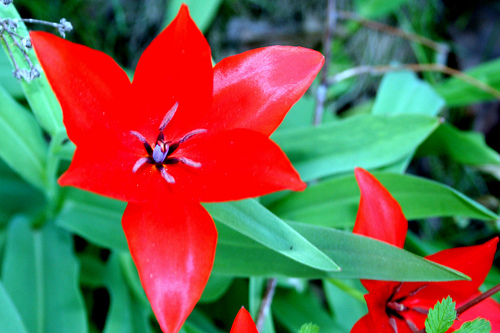

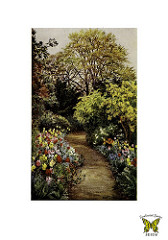

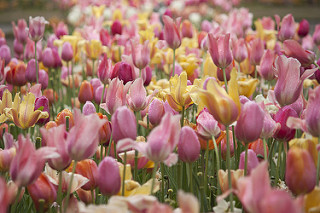

In [18]:
tulips     = list(data_dir.glob('tulips/*'))
sunflowers = list(data_dir.glob('sunflowers/*'))
dandelion  = list(data_dir.glob('dandelion/*'))
roses      = list(data_dir.glob('roses/*'))
daisy      = list(data_dir.glob('daisy/*'))

for image_path in tulips[:3]:
  display.display(Image.open(str(image_path)))

In [ ]:
IMAGE_SIZE = [512, 512]
BATCH_SIZE = 16

#TRAINING_FILENAMES   = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
#VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
#TEST_FILENAMES       = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = ['tulips', 'sunflowers', 'dandelion', 'roses', 'daisy']                                                                                                                                               # 100 - 102

VALIDATION = False
if not VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES+VALIDATION_FILENAMES

## Definindo algumas funções

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

## Carregar os dados

In [ ]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U'))

In [ ]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

## Funções para visualização das imagens

In [ ]:
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [ ]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

In [ ]:

with strategy.scope():
    dn201 = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    dn201.trainable = True # Full Training
    
    model1 = tf.keras.Sequential([
        dn201,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model1.summary()
"""
input_shape = (512,512, 3)
with strategy.scope():

    pretrained_model0 = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model1 = efn.EfficientNetB7(weights='noisy-student', include_top=False, input_shape=[*IMAGE_SIZE, 3])   
    pretrained_model0.trainable = True # False = transfer learning, True = fine-tuning
    pretrained_model1.trainable = True # False = transfer learning, True = fine-tuning

    model0 = tf.keras.Sequential([
        pretrained_model0,
        tf.keras.layers.GlobalMaxPooling2D()

    ])
    model1 = tf.keras.Sequential([
        pretrained_model1,
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1920, activation='relu')
    ])       
    
    #model_concat =tf.keras.layers.add([model0.output, model1.output)
    model_concat =tf.keras.layers.average([model0.output, model1.output])
    #model_concat =tf.keras.layers.maximum([model0.output, model1.output])
    #model_concat =tf.keras.layers.concatenate([model0.output, model1.output] , axis=-1)
    #model_concat = tf.keras.layers.Dropout(0.5)(model_concat)
    model_concat = tf.keras.layers.Dense(len(CLASSES), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(model_concat) 
    modelg = tf.keras.Model(inputs=[model0.input, model1.input], outputs=model_concat )
    inputs = tf.keras.layers.Input(shape = input_shape )
    hidden = modelg([inputs, inputs])
    model = tf.keras.Model(inputs=inputs, outputs=hidden) 
       
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()
tf.keras.utils.plot_model(model,to_file='demo.png',show_shapes=True)
"""

In [ ]:
with strategy.scope():
    enb7 = efn.EfficientNetB7(weights='noisy-student', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    enb7.trainable = True # Full Training
    
    model2 = tf.keras.Sequential([
        enb7,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()

In [ ]:
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = np.random.random_sample() * LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)

In [ ]:

if VALIDATION:
    history1 = model1.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=42, validation_data=get_validation_dataset(), callbacks = [lr_callback, es_callback])
else:
    history1 = model1.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=32, callbacks = [lr_callback])
    

In [ ]:

if VALIDATION:
    history2 = model2.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=42, validation_data=get_validation_dataset(), callbacks = [lr_callback, es_callback])
else:
    history2 = model2.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=32, callbacks = [lr_callback])  

In [ ]:
if VALIDATION:
    display_training_curves(history1.history['loss'], history1.history['val_loss'], 'loss', 211)
    display_training_curves(history2.history['loss'], history2.history['val_loss'], 'loss', 211)
    display_training_curves(history1.history['sparse_categorical_accuracy'], history1.history['val_sparse_categorical_accuracy'], 'accuracy', 212)
    display_training_curves(history2.history['sparse_categorical_accuracy'], history2.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

In [ ]:
if VALIDATION:    
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    #cm_probabilities = (model1.predict(images)+model2.predict(images))/2
    cm_probabilities = (model1.predict(images_ds)*0.33)+model2.predict(images_ds)*0.67
    #cm_probabilities = model.predict(images_ds)
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)

In [ ]:
if VALIDATION: 
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

In [ ]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
#probabilities = (model1.predict(test_images_ds)+model2.predict(test_images_ds))/2 # using average model probability
probabilities = (model1.predict(test_images_ds)*0.33)+model2.predict(test_images_ds)*0.67
#probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

## Validação do modelo

In [ ]:
if VALIDATION:
    dataset = get_validation_dataset()
    dataset = dataset.unbatch().batch(20)
    batch = iter(dataset)

In [ ]:
# run this cell again for next set of images
if VALIDATION:
    images, labels = next(batch)
    probabilities = (model1.predict(images)*0.33)+model2.predict(images)*0.67
    predictions = np.argmax(probabilities, axis=-1)
    display_batch_of_images((images, labels), predictions)